In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import warnings

from skbio.stats.distance import permanova
from gemelli.rpca import joint_rpca, feature_correlation_table, rpca
from scipy.stats import spearmanr
from src.helper_functions import simple_blocks

warnings.filterwarnings('ignore', category=RuntimeWarning)
%matplotlib inline

0


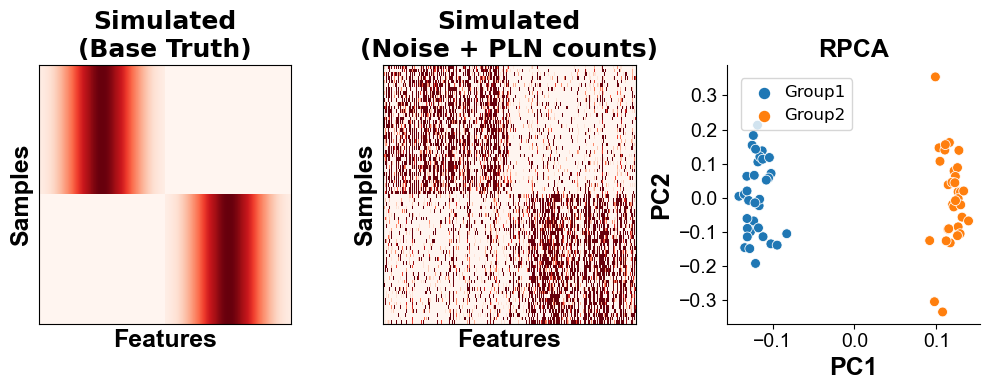

300


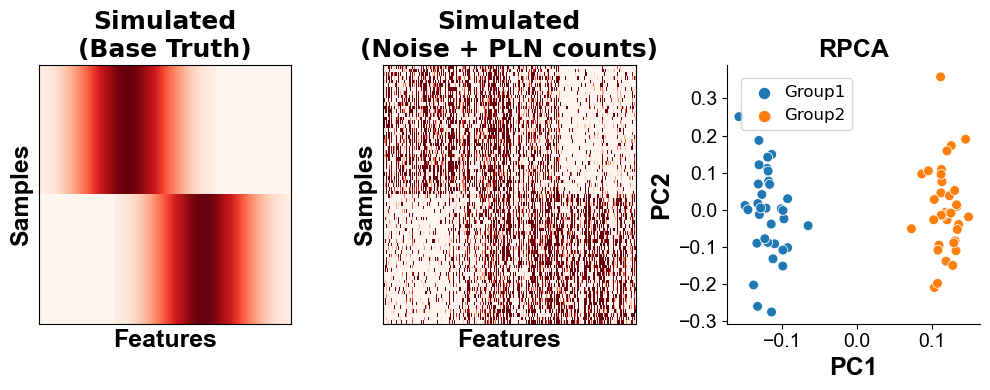

600


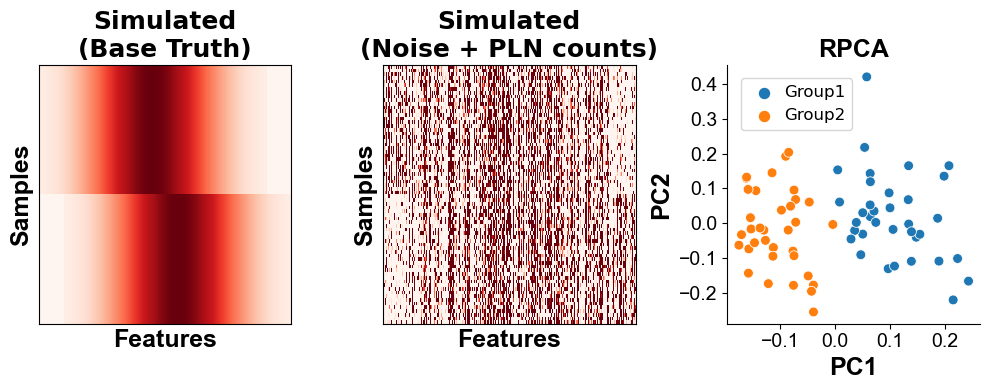

750


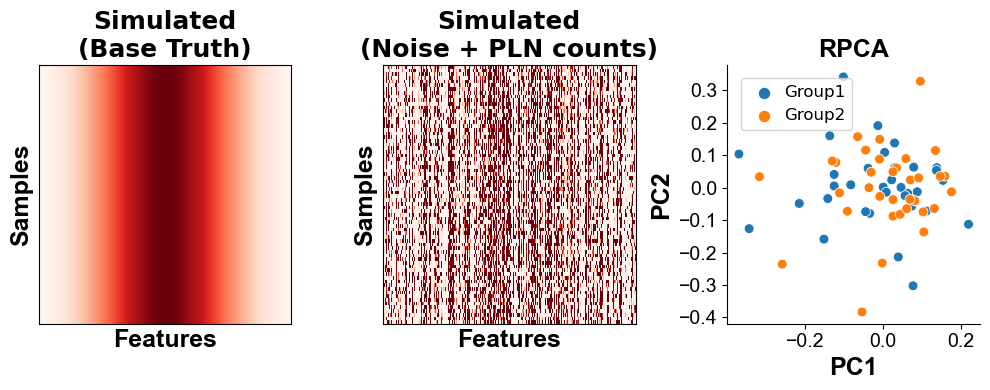

In [8]:
n_samples = 70
n_features = 1500
tables_save_joint = {}

for i, p_overlap in enumerate([0, 0.2, 0.4, 0.5]):
    
    overlap_ = int(n_features * p_overlap)
    print(overlap_)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    # build simple three block model
    np.random.seed(42)
    bt_base_tmp, bt_sim_tmp, mf_sim_tmp = simple_blocks(n_samples, n_features, overlap=overlap_, n_blocks=2)
    tables_save_joint[p_overlap] = bt_sim_tmp.copy()
    
    # run RPCA
    ord_tmp, dtmp = rpca(bt_sim_tmp)
    splot = pd.concat([ord_tmp.samples, mf_sim_tmp], axis=1)
    f_stat = permanova(dtmp, mf_sim_tmp['groups'])['test statistic']

    ax1.imshow(bt_base_tmp.matrix_data.toarray().T, cmap='Reds', aspect='auto', interpolation='nearest')
    ax2.imshow(bt_sim_tmp.matrix_data.toarray().T, cmap='Reds', aspect='auto', interpolation='nearest', vmax=10)
    sns.scatterplot(x='PC1', y='PC2', hue='groups', data=splot, s=50, ax=ax3)

    ax1.set_title('Simulated\n(Base Truth)', color='black', weight='bold', fontsize=18)
    ax2.set_title('Simulated\n(Noise + PLN counts)', weight='bold', color='black', fontsize=18)
    ax3.set_title('RPCA', color='black', weight='bold', fontsize=18, fontname='Arial')
    ax3.set_ylabel('PC2', color='black', weight='bold', fontsize=18, fontname='Arial')
    ax3.set_xlabel('PC1', color='black', weight='bold', fontsize=18, fontname='Arial')

    for ax in [ax1, ax2]:
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_ylabel('Samples', color='black', weight='bold', fontsize=18, fontname='Arial')
        ax.set_xlabel('Features', color='black', weight='bold', fontsize=18, fontname='Arial')

    ax = ax3
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
            
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(14)

    #increase legend font size
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, ['Group1', 'Group2'], loc='upper left', 
                        prop={'size':12}, borderaxespad=0.8,
                        title="", handletextpad=0.2,
                        fancybox=True, framealpha=.8,
                        ncol=1, markerscale=1.2)

    plt.tight_layout()
    plt.savefig('../../results/supp-fig4A-RPCA-{}.pdf'.format(i+1), 
                dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.savefig('../../results/supp-fig4A-RPCA-{}.png'.format(i+1), 
                dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()


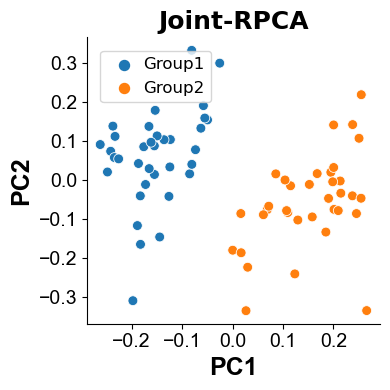

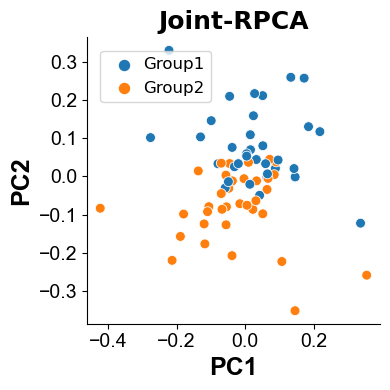

In [9]:
true_lbls = list(mf_sim_tmp[mf_sim_tmp.groups == 'g0'].index[:10]) + list(mf_sim_tmp[mf_sim_tmp.groups != 'g0'].index[:10])
mf_sim_tmp['train_test'] = 'train'
mf_sim_tmp.loc[true_lbls, 'train_test'] = 'test'

for i, joint_use_add in enumerate([(0.2, 0.4), (0.4, 0.5)]):
    
    ord_, _, _ = joint_rpca([tables_save_joint[joint_use_x].copy()
                             for joint_use_x in joint_use_add],
                            max_iterations=5,
                            sample_metadata=mf_sim_tmp,
                            train_test_column='train_test')
    ord_plt = pd.concat([ord_.samples, mf_sim_tmp], axis=1)

    fig, ax3 = plt.subplots(1, 1, figsize=(4, 4))

    sns.scatterplot(x='PC2', y='PC1', hue='groups', 
                    s=50, data=ord_plt, ax=ax3)

    ax3.set_title('Joint-RPCA', color='black', weight='bold', fontsize=18)
    ax3.set_ylabel('PC2', color='black', weight='bold', fontsize=18, fontname='Arial')
    ax3.set_xlabel('PC1', color='black', weight='bold', fontsize=18, fontname='Arial')

    ax = ax3
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(14)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, ['Group1', 'Group2'], loc='upper left', 
                        prop={'size':12}, borderaxespad=0.8,
                        title="", handletextpad=0.2,
                        fancybox=True, framealpha=.8,
                        ncol=1, markerscale=1.2)
    
    plt.savefig('../../results/supp-fig4A-JointRPCA-{}.pdf'.format(i+1), 
                dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.savefig('../../results/supp-fig4A-JointRPCA-{}.png'.format(i+1), 
                dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

    plt.tight_layout()
    plt.show()

In [10]:
n_samples = 20
tables_test = {}
fold = 0
for n_features in [20, 20*10, 20*100]:
    for fp_ in range(5):
        #print(fold)
        for p_overlap in [0.1, 0.2, 0.3, 0.4, 0.5]:
            overlap_ = int(n_features * p_overlap)
            # build simple three block model
            np.random.seed(42 + fold + overlap_)
            bt_base_tmp, bt_sim_tmp, mf_sim_tmp = simple_blocks(n_samples, n_features,
                                                                n_blocks=2, overlap=overlap_)
            # make train-test
            test_ = [f for _, df in mf_sim_tmp.groupby('groups') for f in df.index[:int(n_samples/2 * 0.5)]]
            mf_sim_tmp['train_test'] = 'train'
            mf_sim_tmp.loc[test_, 'train_test'] = 'test'
            # run RPCA
            ord_tmp, dtmp, dist_tmp = joint_rpca([bt_sim_tmp], sample_metadata=mf_sim_tmp,
                                                 train_test_column='train_test',
                                                 max_iterations=5)
            splot = pd.concat([ord_tmp.samples, mf_sim_tmp], axis=1)
            f_stat = permanova(dtmp, mf_sim_tmp.loc[list(dtmp.ids), 'groups'])['test statistic']
            tables_test[(fold, p_overlap)] = [bt_sim_tmp, mf_sim_tmp, f_stat]
        fold += 1 

In [ ]:
# only save once for to make it easier to exactly reproduce. 
#with open('../data/simulations/time_and_breakpoint/simulations_effect_sizes.pickle', 'wb') as handle:
#   pickle.dump(tables_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open('../../data/simulations/time_and_breakpoint/simulations_effect_sizes.pickle', 'rb') as handle:
#    tables_test = pickle.load(handle)
    
#tables_test.keys()


In [11]:
def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

es_compare = {}

# stacked-RPCA
for fold_ in range(15):
    #print(fold_)
    for k1, k2 in [(0.1, 0.1), (0.1, 0.2),
                   (0.1, 0.3), (0.1, 0.5)]:
        #print((k1, k2))
        corr_tmps = []
        sample_ords = []
        for _ in range(5):
            sord, _, _= joint_rpca([tables_test[(fold_, k1)][0],
                                    tables_test[(fold_, k2)][0]],
                                   sample_metadata=tables_test[(fold_, k1)][1],
                                   train_test_column='train_test',
                                   max_iterations=5)
            corr_tmp = feature_correlation_table(sord)
            corr_tmps.append(corr_tmp)
            sample_ords.append(sord.samples)
            
        corr_sim = []
        for i, j in list(itertools.combinations(range(0, len(corr_tmps) - 1), 2)):
            corr_sim.append(spearmanr(upper(corr_tmps[i]),
                                      upper(corr_tmps[j])).correlation)

        start_time = time.time()
        ord_tmp, dist_tmp, cv_tmp = joint_rpca([tables_test[(fold_, k1)][0],
                                                tables_test[(fold_, k2)][0]],
                                               sample_metadata=tables_test[(fold_, k1)][1],
                                               train_test_column='train_test',
                                               max_iterations=5)
        corr_tmp = feature_correlation_table(sord)
        time_tmp = time.time() - start_time
        
        # only run f-stat for first 5 sims
        if tables_test[(fold_, k1)][0].shape[0] == 20:
            joint_es = permanova(dist_tmp, tables_test[(fold_, k1)][1].loc[list(dist_tmp.ids), 'groups'])['test statistic']
        else:
            joint_es = np.nan
        es_compare[(fold_, k1, k2,  )] = [tables_test[(fold_, k1)][-1],
                                          tables_test[(fold_, k2)][-1],
                                          joint_es,
                                          np.mean(corr_sim),
                                          np.std(corr_sim),
                                          time_tmp]

In [12]:
es_compare_df = pd.DataFrame(es_compare).T
n_samples = 20
es_compare_df.columns = ['fes_one','fes_two','joint_es','corr','corr_std', 'time_sec']
es_compare_df = es_compare_df.reset_index()
es_compare_df = es_compare_df.rename({'level_0':'fold',
                                      'level_1':'es_one',
                                      'level_2':'es_two',
                                      'level_3':'n-features'}, axis=1)
es_compare_df['maxf'] = es_compare_df[['fes_one','fes_two']].mean(1)
es_compare_df['number_features'] = [tables_test[(f_, 0.1)][0].shape[0] for f_ in es_compare_df.fold]
es_compare_df['feature_multiple'] = (es_compare_df['number_features'] / n_samples).astype(int)
#es_compare_df.to_csv('../../results/effect-size-bench-stats.csv')

es_compare_df.head(5)

,fold,es_one,es_two,fes_one,fes_two,joint_es,corr,corr_std,time_sec,maxf,number_features,feature_multiple
0,0,0.1,0.1,7.856857,7.856857,7.856857,0.999961,4.620823e-06,0.027235,7.856857,20,1
1,0,0.1,0.2,7.856857,5.753848,7.624772,1.000000,8.021429e-08,0.030735,6.805353,20,1
2,0,0.1,0.3,7.856857,1.833056,6.680742,1.000000,5.067287e-08,0.034591,4.844956,20,1
3,0,0.1,0.5,7.856857,0.763322,4.279499,1.000000,3.649873e-09,0.029094,4.310089,20,1
4,1,0.1,0.1,8.778268,8.778268,8.778268,0.999961,4.932744e-06,0.030206,8.778268,20,1


{200, 20, 2000}
SignificanceResult(statistic=0.8406015037593983, pvalue=3.483775929626355e-06)


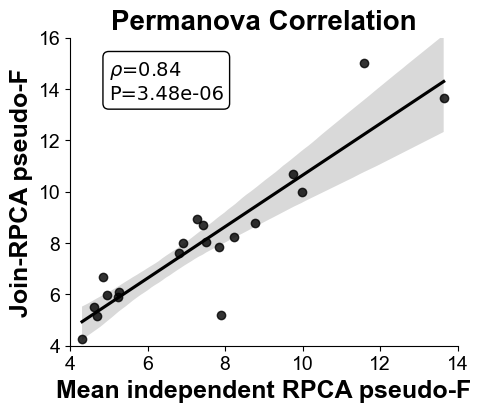

In [14]:
es_compare_df_plt = es_compare_df.copy().dropna(subset=['joint_es'])
print(set(es_compare_df.number_features))

fig, ax = plt.subplots(1,1, figsize=(5, 4))

sns.regplot(x='maxf', y='joint_es', data=es_compare_df_plt, color='black', ax=ax)

ax.set_title('Permanova Correlation', 
             color='black', weight='bold', 
             fontsize=20, fontname='Arial')
ax.set_ylabel('Join-RPCA pseudo-F', 
              color='black', weight='bold', 
              fontsize=18, fontname='Arial')
ax.set_xlabel('Mean independent RPCA pseudo-F', 
              color='black', weight='bold', 
              fontsize=18, fontname='Arial')

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)

ax.set_ylim(4, 16)
ax.set_xlim(4, 14)

print(spearmanr(es_compare_df_plt.maxf, es_compare_df_plt.joint_es))
rho, p = spearmanr(es_compare_df_plt.maxf, es_compare_df_plt.joint_es)
p = str(p)[:4] + str(p)[str(p).index('e'):]
sts_box = "$\\rho$=%.2f\nP=%s" % (rho, p)
props = dict(boxstyle='round', facecolor='none', edgecolor='black')
ax.text(0.1, 0.8, sts_box, transform=ax.transAxes, bbox=props, ha='left', fontsize=14)

plt.savefig('../../results/supp-fig4B.pdf', 
            dpi=600,
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/supp-fig4B.png', 
            dpi=600,
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


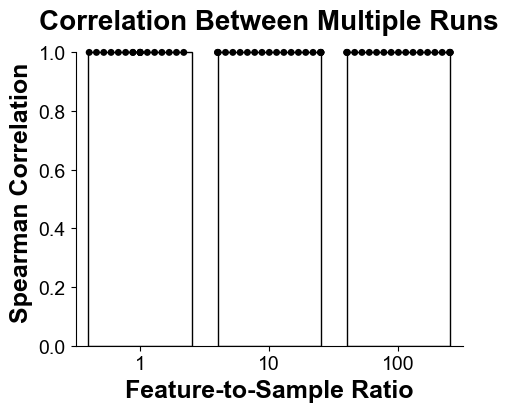

In [16]:
es_compare_df_plt = es_compare_df.copy()

fig, ax = plt.subplots(1,1, figsize=(5, 4))

sns.swarmplot(x='feature_multiple', y='corr', color='black', s=5, data=es_compare_df_plt, ax=ax)
sns.barplot(x='feature_multiple', y='corr', color='white', data=es_compare_df_plt, ax=ax)

for patch in ax.patches:
    clr = patch.get_facecolor()
    patch.set_edgecolor('black')

ax.set_title('Correlation Between Multiple Runs', 
             color='black', weight='bold', 
             fontsize=20, fontname='Arial')
ax.set_ylabel('Spearman Correlation', 
              color='black', weight='bold', 
              fontsize=18, fontname='Arial')
ax.set_xlabel('Feature-to-Sample Ratio', 
              color='black', weight='bold', 
              fontsize=18, fontname='Arial')

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(14)

ax.spines['left'].set_bounds(0, 1)

plt.savefig('../../results/supp-fig4C.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/supp-fig4C.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()